In [1]:
from forse.tools.nn_tools import *
from forse.tools.img_tools import *
from forse.tools.mix_tools import *
from keras.models import Sequential, Model, load_model
from keras.layers import UpSampling2D, Conv2D, Activation, BatchNormalization
from keras.layers import Reshape, Dense, Input
from keras.layers import LeakyReLU, Dropout, Flatten, ZeroPadding2D
from keras.optimizers import Adam, RMSprop
import keras.backend as K
import os
import matplotlib.pyplot as plt
import datetime
from  functools import partial

Using TensorFlow backend.


In [2]:
class WGAN:
    def __init__(self, output_directory, img_size):
        self.img_size = img_size
        self.channels = 1
        self.kernel_size = 5
        self.output_directory = output_directory
        self.n_critic = 10
        self.clip_value = 0.01
        self.batch_size = 1
        self.gradient_penalty_weight = 10

    def wasserstein_loss(self, y_true, y_pred, true_gen_imgs):
        y_pred_true = y_pred[0:self.batch_size]
        y_pred_gen = y_pred[self.batch_size:]
        C_cost = K.mean(y_pred_gen) - K.mean(y_pred_true)
        alpha = K.random_uniform(
            shape=[self.batch_size], 
            minval=0.,
            maxval=1.
            )
        real_data = true_gen_imgs[0:self.batch_size]
        fake_data = true_gen_imgs[self.batch_size:]
        differences = fake_data - real_data
        interpolates = real_data + (alpha*differences)
        gradients = K.gradients(self.critic(interpolates), [interpolates])[0]
        gradients_sqr = K.square(gradients)
        gradients_sqr_sum = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        gradient_penalty = self.gradient_penalty_weight * K.square(1 - gradient_l2_norm)
        C_cost += K.mean(gradient_penalty)
        return C_cost
          
    def C_loss(self, y_true, y_pred):
        y_pred_true = y_pred[0:self.batch_size]
        y_pred_gen = y_pred[self.batch_size:]
        C_cost = K.mean(y_pred_gen) - K.mean(y_pred_true)
        return C_cost
    
    def G_loss(self, y_true, y_pred):
        G_cost = - K.mean(y_pred)
        return G_cost
      
    def build_generator(self):
        img_shape = (self.img_size[0], self.img_size[1], self.channels)
        model = Sequential()
        model.add(Conv2D(64, kernel_size=self.kernel_size, padding="same")) # 64x64x64
        model.add(LeakyReLU(alpha=0.1))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=self.kernel_size, padding="same", strides=2)) #32x32x128
        model.add(LeakyReLU(alpha=0.1))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=self.kernel_size, padding="same", strides=2)) #16x16x256
        model.add(LeakyReLU(alpha=0.1))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())  #32x32x128
        model.add(Conv2D(128, kernel_size=self.kernel_size, padding="same"))
        model.add(LeakyReLU(alpha=0.1))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())  #64x64x64
        model.add(Conv2D(64, kernel_size=self.kernel_size, padding="same"))
        model.add(LeakyReLU(alpha=0.1))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=self.kernel_size, padding="same"))
        model.add(Activation("tanh"))
        img_in = Input(shape=img_shape)
        img_out = model(img_in)
        return Model(img_in, img_out)
    
    def build_critic(self):
        img_shape = (self.img_size[0], self.img_size[1], self.channels)
        model = Sequential()
        model.add(Conv2D(64, kernel_size=self.kernel_size, strides=1, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.1))
        #model.add(Dropout(0.25))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=self.kernel_size, strides=2, padding="same"))
        #model.add(Dropout(0.25))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=self.kernel_size, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.1))
        #model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))
        img = Input(shape=img_shape)
        validity = model(img)
        return Model(img, validity) 

    def build_gan(self):
        img_shape = (self.img_size[0], self.img_size[1], self.channels)
        optimizer = Adam(0.0001, beta_1=0.5, beta_2=0.999)
        self.critic = self.build_critic()
        self.critic.trainable = True
        self.critic.compile(loss=self.C_loss, optimizer=optimizer)
        self.generator = self.build_generator()
        self.generator.compile(loss=self.G_loss, optimizer=optimizer)
        z = Input(shape=img_shape)
        img = self.generator(z)
        self.critic.trainable = False
        valid = self.critic(img)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.G_loss, optimizer=optimizer)
        
    def build_gan2(self):
        img_shape = (self.img_size[0], self.img_size[1], self.channels)
        optimizer = Adam(0.0001, beta_1=0.5, beta_2=0.999)
        self.critic = self.build_critic()
        self.generator = self.build_generator()
        self.critic.trainable = True
        self.critic.compile(loss=self.C_loss, optimizer=optimizer)
        z = Input(shape=img_shape)
        img = self.generator(z)
        self.critic.trainable = False
        self.critic.compile(loss=self.G_loss, optimizer=optimizer)
        valid = self.critic(img)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.G_loss, optimizer=optimizer)
        self.critic.trainable = True
        self.critic.compile(loss=self.C_loss, optimizer=optimizer)
        
    def train_new(self, epochs, patches_file, save_interval=100, seed=4324):
        #self.build_gan2
        img_shape = (self.img_size[0], self.img_size[1], self.channels)
        X_train, X_test, Y_train, Y_test = load_training_set(patches_file, seed=seed)
        print('built gen and crit', datetime.datetime.now().time())
        optimizer = Adam(0.0001, beta_1=0.5, beta_2=0.999)
        dummy_vector_1 = np.zeros((self.batch_size, 1))
        dummy_vector_2 = np.zeros((self.batch_size*2, 1))
        for epoch in range(epochs):
            print(epoch, datetime.datetime.now().time())
            K.clear_session()
            self.critic = self.build_critic()
            self.generator = self.build_generator()
            idx = np.random.randint(0, X_train.shape[0], self.batch_size)
            gen_imgs = self.generator.predict(X_train[idx])
            true_imgs = Y_train[idx]
            true_gen_imgs = np.concatenate([true_imgs, gen_imgs], axis=0)
            critic_loss = partial(self.wasserstein_loss,
                          true_gen_imgs=true_gen_imgs,
                          )
            critic_loss.__name__ = 'critic_loss'
            self.critic.trainable = True
            self.critic.compile(loss=critic_loss, optimizer=optimizer)
            for _ in range(self.n_critic):
                c_loss = self.critic.train_on_batch(true_gen_imgs, dummy_vector_2)
            #self.generator.compile(loss=self.G_loss, optimizer=optimizer)
            z = Input(shape=img_shape)
            img = self.generator(z)
            self.critic.trainable = False
            self.critic.compile(loss=self.G_loss, optimizer=optimizer)
            valid = self.critic(img)
            self.combined = Model(z, valid)
            self.combined.compile(loss=self.G_loss, optimizer=optimizer)
            g_loss = self.combined.train_on_batch(X_train[idx], dummy_vector_1)
            if epoch % (save_interval) == 0:
                print(f"{epoch} [C loss: {c_loss}] [G loss: {g_loss}]")

    def train_new2(self, epochs, patches_file, save_interval=100, seed=4324):
        optimizer = Adam(0.0001, beta_1=0.5, beta_2=0.999)
        img_shape = (self.img_size[0], self.img_size[1], self.channels)
        X_train, X_test, Y_train, Y_test = load_training_set(patches_file, seed=seed)
        print('built gen and crit', datetime.datetime.now().time())
        self.build_gan2()
        dummy_vector_1 = np.zeros((self.batch_size, 1))
        dummy_vector_2 = np.zeros((self.batch_size*2, 1))
        for epoch in range(epochs):
            print(epoch, datetime.datetime.now().time())
            idx = np.random.randint(0, X_train.shape[0], self.batch_size)
            gen_imgs = self.generator.predict(X_train[idx])
            #print('GEN')
            #self.generator.summary()
            #print('predict', datetime.datetime.now().time())
            true_imgs = Y_train[idx]
            true_gen_imgs = np.concatenate([true_imgs, gen_imgs], axis=0)
            #critic_loss = partial(self.wasserstein_loss,
                          #true_gen_imgs=true_gen_imgs,
                          #)
            #critic_loss.__name__ = 'critic_loss'
            #self.critic.trainable = True
            #self.critic.compile(loss=critic_loss, optimizer=optimizer)
            #print('CRIT')
            #self.critic.summary()
            for _ in range(10):
                c_loss = self.critic.train_on_batch(true_gen_imgs, dummy_vector_2)
            #self.critic.trainable = False
            #self.critic.compile(loss=self.G_loss, optimizer=optimizer)
            #print('COMB')
            #self.combined.summary()
            g_loss = self.combined.train_on_batch(X_train[idx], dummy_vector_1)
            if epoch % (save_interval) == 0:
                print(f"{epoch} [C loss: {c_loss}] [G loss: {g_loss}]")
            #K.clear_session()


In [3]:
wgan = WGAN(output_directory='/global/homes/k/krach/scratch/NNforFG/WGAN/tests', img_size=(64, 64))

In [4]:
training_path = '/global/homes/k/krach/scratch/NNforFG/training_set/'
training_file = 'training_set_1000patches_20x20deg_T_HR1deg_LR5deg_Npix64_set2.npy'
patch_file = training_path+training_file

In [5]:
X_train, X_test, Y_train, Y_test = load_training_set(patch_file, seed=0)

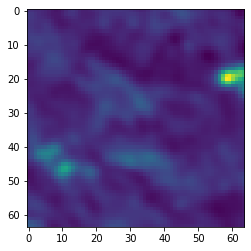

In [6]:
plt.imshow(Y_train[200, :, :, 0])

In [7]:
wgan.train_new(epochs=100, patches_file=patch_file, save_interval=1)

built gen and crit 04:07:02.535807
0 04:07:03.326692
0 [C loss: -18.993566513061523] [G loss: 0.08780089765787125]
1 04:07:06.615340
1 [C loss: -58.81938934326172] [G loss: 1.90764582157135]
2 04:07:08.565137
2 [C loss: -26.771055221557617] [G loss: -1.5711002349853516]
3 04:07:10.302466
3 [C loss: -50.60926818847656] [G loss: -3.8565564155578613]
4 04:07:12.241905
4 [C loss: -39.848480224609375] [G loss: -2.178434133529663]
5 04:07:14.202179
5 [C loss: -50.868995666503906] [G loss: 2.1451709270477295]
6 04:07:15.959985
6 [C loss: -59.99124526977539] [G loss: 3.738410472869873]
7 04:07:17.774933
7 [C loss: -49.82536315917969] [G loss: 5.947651386260986]
8 04:07:19.779698
8 [C loss: -105.9674301147461] [G loss: 3.664461135864258]
9 04:07:21.680696
9 [C loss: -79.49557495117188] [G loss: -5.930476665496826]
10 04:07:23.420055
10 [C loss: -63.36152648925781] [G loss: -8.851709365844727]
11 04:07:25.424105
11 [C loss: -77.07035064697266] [G loss: -3.7923715114593506]
12 04:07:27.162406
12 

KeyboardInterrupt: 

In [47]:
wgan.critic.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1091585   
Total params: 1,091,585
Trainable params: 0
Non-trainable params: 1,091,585
_________________________________________________________________


In [34]:
wgan.generator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 64, 64, 1)         2051841   
Total params: 2,051,841
Trainable params: 2,051,841
Non-trainable params: 0
_________________________________________________________________


In [35]:
wgan.combined.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
model_2 (Model)              (None, 64, 64, 1)         2051841   
_________________________________________________________________
model_1 (Model)              multiple                  1091585   
Total params: 3,143,426
Trainable params: 2,051,841
Non-trainable params: 1,091,585
_________________________________________________________________


In [36]:
dummy_vector_1 = np.zeros((1, 1))
pippo = wgan.combined.evaluate(X_train[0:1],dummy_vector_1 )

1/1 [==============================] - 0s 40ms/step


In [37]:
pippo

-124.1782455444336

In [38]:
pippo = wgan.generator.predict(X_train[0:1])

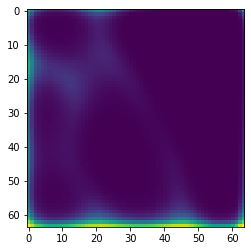

In [39]:
plt.imshow(pippo[0, :, :, 0])

In [2]:
"""An implementation of the improved WGAN described in https://arxiv.org/abs/1704.00028
The improved WGAN has a term in the loss function which penalizes the network if its
gradient norm moves away from 1. This is included because the Earth Mover (EM) distance
used in WGANs is only easy to calculate for 1-Lipschitz functions (i.e. functions where
the gradient norm has a constant upper bound of 1).
The original WGAN paper enforced this by clipping weights to very small values
[-0.01, 0.01]. However, this drastically reduced network capacity. Penalizing the
gradient norm is more natural, but this requires second-order gradients. These are not
supported for some tensorflow ops (particularly MaxPool and AveragePool) in the current
release (1.0.x), but they are supported in the current nightly builds
(1.1.0-rc1 and higher).
To avoid this, this model uses strided convolutions instead of Average/Maxpooling for
downsampling. If you wish to use pooling operations in your discriminator, please ensure
you update Tensorflow to 1.1.0-rc1 or higher. I haven't tested this with Theano at all.
The model saves images using pillow. If you don't have pillow, either install it or
remove the calls to generate_images.
"""
import argparse
import os
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers.merge import _Merge
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.datasets import mnist
from keras import backend as K
from functools import partial

try:
    from PIL import Image
except ImportError:
    print('This script depends on pillow! '
          'Please install it (e.g. with pip install pillow)')
    exit()

BATCH_SIZE = 64
# The training ratio is the number of discriminator updates
# per generator update. The paper uses 5.
TRAINING_RATIO = 5
GRADIENT_PENALTY_WEIGHT = 10  # As per the paper


def wasserstein_loss(y_true, y_pred):
    """Calculates the Wasserstein loss for a sample batch.
    The Wasserstein loss function is very simple to calculate. In a standard GAN, the
    discriminator has a sigmoid output, representing the probability that samples are
    real or generated. In Wasserstein GANs, however, the output is linear with no
    activation function! Instead of being constrained to [0, 1], the discriminator wants
    to make the distance between its output for real and generated samples as
    large as possible.
    The most natural way to achieve this is to label generated samples -1 and real
    samples 1, instead of the 0 and 1 used in normal GANs, so that multiplying the
    outputs by the labels will give you the loss immediately.
    Note that the nature of this loss means that it can be (and frequently will be)
    less than 0."""
    return K.mean(y_true * y_pred)


def gradient_penalty_loss(y_true, y_pred, averaged_samples,
                          gradient_penalty_weight):
    """Calculates the gradient penalty loss for a batch of "averaged" samples.
    In Improved WGANs, the 1-Lipschitz constraint is enforced by adding a term to the
    loss function that penalizes the network if the gradient norm moves away from 1.
    However, it is impossible to evaluate this function at all points in the input
    space. The compromise used in the paper is to choose random points on the lines
    between real and generated samples, and check the gradients at these points. Note
    that it is the gradient w.r.t. the input averaged samples, not the weights of the
    discriminator, that we're penalizing!
    In order to evaluate the gradients, we must first run samples through the generator
    and evaluate the loss. Then we get the gradients of the discriminator w.r.t. the
    input averaged samples. The l2 norm and penalty can then be calculated for this
    gradient.
    Note that this loss function requires the original averaged samples as input, but
    Keras only supports passing y_true and y_pred to loss functions. To get around this,
    we make a partial() of the function with the averaged_samples argument, and use that
    for model training."""
    # first get the gradients:
    #   assuming: - that y_pred has dimensions (batch_size, 1)
    #             - averaged_samples has dimensions (batch_size, nbr_features)
    # gradients afterwards has dimension (batch_size, nbr_features), basically
    # a list of nbr_features-dimensional gradient vectors
    gradients = K.gradients(y_pred, averaged_samples)[0]
    # compute the euclidean norm by squaring ...
    gradients_sqr = K.square(gradients)
    #   ... summing over the rows ...
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
    #   ... and sqrt
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    # compute lambda * (1 - ||grad||)^2 still for each single sample
    gradient_penalty = gradient_penalty_weight * K.square(1 - gradient_l2_norm)
    # return the mean as loss over all the batch samples
    return K.mean(gradient_penalty)


def make_generator():
    """Creates a generator model that takes a 100-dimensional noise vector as a "seed",
    and outputs images of size 28x28x1."""
    model = Sequential()
    model.add(Dense(1024, input_dim=100))
    model.add(LeakyReLU())
    model.add(Dense(128 * 7 * 7))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    if K.image_data_format() == 'channels_first':
        model.add(Reshape((128, 7, 7), input_shape=(128 * 7 * 7,)))
        bn_axis = 1
    else:
        model.add(Reshape((7, 7, 128), input_shape=(128 * 7 * 7,)))
        bn_axis = -1
    model.add(Conv2DTranspose(128, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization(axis=bn_axis))
    model.add(LeakyReLU())
    model.add(Convolution2D(64, (5, 5), padding='same'))
    model.add(BatchNormalization(axis=bn_axis))
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(64, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization(axis=bn_axis))
    model.add(LeakyReLU())
    # Because we normalized training inputs to lie in the range [-1, 1],
    # the tanh function should be used for the output of the generator to ensure
    # its output also lies in this range.
    model.add(Convolution2D(1, (5, 5), padding='same', activation='tanh'))
    return model


def make_discriminator():
    """Creates a discriminator model that takes an image as input and outputs a single
    value, representing whether the input is real or generated. Unlike normal GANs, the
    output is not sigmoid and does not represent a probability! Instead, the output
    should be as large and negative as possible for generated inputs and as large and
    positive as possible for real inputs.
    Note that the improved WGAN paper suggests that BatchNormalization should not be
    used in the discriminator."""
    model = Sequential()
    if K.image_data_format() == 'channels_first':
        model.add(Convolution2D(64, (5, 5), padding='same', input_shape=(1, 28, 28)))
    else:
        model.add(Convolution2D(64, (5, 5), padding='same', input_shape=(28, 28, 1)))
    model.add(LeakyReLU())
    model.add(Convolution2D(128, (5, 5), kernel_initializer='he_normal',
                            strides=[2, 2]))
    model.add(LeakyReLU())
    model.add(Convolution2D(128, (5, 5), kernel_initializer='he_normal', padding='same',
                            strides=[2, 2]))
    model.add(LeakyReLU())
    model.add(Flatten())
    model.add(Dense(1024, kernel_initializer='he_normal'))
    model.add(LeakyReLU())
    model.add(Dense(1, kernel_initializer='he_normal'))
    return model


def tile_images(image_stack):
    """Given a stacked tensor of images, reshapes them into a horizontal tiling for
    display."""
    assert len(image_stack.shape) == 3
    image_list = [image_stack[i, :, :] for i in range(image_stack.shape[0])]
    tiled_images = np.concatenate(image_list, axis=1)
    return tiled_images


class RandomWeightedAverage(_Merge):
    """Takes a randomly-weighted average of two tensors. In geometric terms, this
    outputs a random point on the line between each pair of input points.
    Inheriting from _Merge is a little messy but it was the quickest solution I could
    think of. Improvements appreciated."""

    def _merge_function(self, inputs):
        weights = K.random_uniform((BATCH_SIZE, 1, 1, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])


def generate_images(generator_model, output_dir, epoch):
    """Feeds random seeds into the generator and tiles and saves the output to a PNG
    file."""
    test_image_stack = generator_model.predict(np.random.rand(10, 100))
    test_image_stack = (test_image_stack * 127.5) + 127.5
    test_image_stack = np.squeeze(np.round(test_image_stack).astype(np.uint8))
    tiled_output = tile_images(test_image_stack)
    tiled_output = Image.fromarray(tiled_output, mode='L')  # L specifies greyscale
    outfile = os.path.join(output_dir, 'epoch_{}.png'.format(epoch))
    tiled_output.save(outfile)


output_dir = '/global/homes/k/krach/test_MNIST'

# First we load the image data, reshape it and normalize it to the range [-1, 1]
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = np.concatenate((X_train, X_test), axis=0)
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]))
else:
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

# Now we initialize the generator and discriminator.
generator = make_generator()
discriminator = make_discriminator()

# The generator_model is used when we want to train the generator layers.
# As such, we ensure that the discriminator layers are not trainable.
# Note that once we compile this model, updating .trainable will have no effect within
# it. As such, it won't cause problems if we later set discriminator.trainable = True
# for the discriminator_model, as long as we compile the generator_model first.
for layer in discriminator.layers:
    layer.trainable = False
discriminator.trainable = False
generator_input = Input(shape=(100,))
generator_layers = generator(generator_input)
discriminator_layers_for_generator = discriminator(generator_layers)
generator_model = Model(inputs=[generator_input],
                        outputs=[discriminator_layers_for_generator])
# We use the Adam paramaters from Gulrajani et al.
generator_model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9),
                        loss=wasserstein_loss)

# Now that the generator_model is compiled, we can make the discriminator
# layers trainable.
for layer in discriminator.layers:
    layer.trainable = True
for layer in generator.layers:
    layer.trainable = False
discriminator.trainable = True
generator.trainable = False

# The discriminator_model is more complex. It takes both real image samples and random
# noise seeds as input. The noise seed is run through the generator model to get
# generated images. Both real and generated images are then run through the
# discriminator. Although we could concatenate the real and generated images into a
# single tensor, we don't (see model compilation for why).
real_samples = Input(shape=X_train.shape[1:])
generator_input_for_discriminator = Input(shape=(100,))
generated_samples_for_discriminator = generator(generator_input_for_discriminator)
discriminator_output_from_generator = discriminator(generated_samples_for_discriminator)
discriminator_output_from_real_samples = discriminator(real_samples)

# We also need to generate weighted-averages of real and generated samples,
# to use for the gradient norm penalty.
averaged_samples = RandomWeightedAverage()([real_samples,
                                            generated_samples_for_discriminator])
# We then run these samples through the discriminator as well. Note that we never
# really use the discriminator output for these samples - we're only running them to
# get the gradient norm for the gradient penalty loss.
averaged_samples_out = discriminator(averaged_samples)

# The gradient penalty loss function requires the input averaged samples to get
# gradients. However, Keras loss functions can only have two arguments, y_true and
# y_pred. We get around this by making a partial() of the function with the averaged
# samples here.
partial_gp_loss = partial(gradient_penalty_loss,
                          averaged_samples=averaged_samples,
                          gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT)
# Functions need names or Keras will throw an error
partial_gp_loss.__name__ = 'gradient_penalty'

# Keras requires that inputs and outputs have the same number of samples. This is why
# we didn't concatenate the real samples and generated samples before passing them to
# the discriminator: If we had, it would create an output with 2 * BATCH_SIZE samples,
# while the output of the "averaged" samples for gradient penalty
# would have only BATCH_SIZE samples.

# If we don't concatenate the real and generated samples, however, we get three
# outputs: One of the generated samples, one of the real samples, and one of the
# averaged samples, all of size BATCH_SIZE. This works neatly!
discriminator_model = Model(inputs=[real_samples,
                                    generator_input_for_discriminator],
                            outputs=[discriminator_output_from_real_samples,
                                     discriminator_output_from_generator,
                                     averaged_samples_out])
# We use the Adam paramaters from Gulrajani et al. We use the Wasserstein loss for both
# the real and generated samples, and the gradient penalty loss for the averaged samples
discriminator_model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9),
                            loss=[wasserstein_loss,
                                  wasserstein_loss,
                                  partial_gp_loss])
# We make three label vectors for training. positive_y is the label vector for real
# samples, with value 1. negative_y is the label vector for generated samples, with
# value -1. The dummy_y vector is passed to the gradient_penalty loss function and
# is not used.
positive_y = np.ones((BATCH_SIZE, 1), dtype=np.float32)
negative_y = -positive_y
dummy_y = np.zeros((BATCH_SIZE, 1), dtype=np.float32)

for epoch in range(100):
    np.random.shuffle(X_train)
    print("Epoch: ", epoch)
    print("Number of batches: ", int(X_train.shape[0] // BATCH_SIZE))
    discriminator_loss = []
    generator_loss = []
    minibatches_size = BATCH_SIZE * TRAINING_RATIO
    for i in range(int(X_train.shape[0] // (BATCH_SIZE * TRAINING_RATIO))):
        discriminator_minibatches = X_train[i * minibatches_size:
                                            (i + 1) * minibatches_size]
        for j in range(TRAINING_RATIO):
            image_batch = discriminator_minibatches[j * BATCH_SIZE:
                                                    (j + 1) * BATCH_SIZE]
            noise = np.random.rand(BATCH_SIZE, 100).astype(np.float32)
            discriminator_loss.append(discriminator_model.train_on_batch(
                [image_batch, noise],
                [positive_y, negative_y, dummy_y]))
        generator_loss.append(generator_model.train_on_batch(np.random.rand(BATCH_SIZE,
                                                                            100),
                                                             positive_y))
    # Still needs some code to display losses from the generator and discriminator,
    # progress bars, etc.
    generate_images(generator, output_dir, epoch)

Epoch:  0
Number of batches:  1093


/global/homes/k/krach/usr/python_prefix_3.7/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/global/homes/k/krach/usr/python_prefix_3.7/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:  1
Number of batches:  1093
Epoch:  2
Number of batches:  1093
Epoch:  3
Number of batches:  1093
Epoch:  4
Number of batches:  1093
Epoch:  5
Number of batches:  1093
Epoch:  6
Number of batches:  1093
Epoch:  7
Number of batches:  1093
Epoch:  8
Number of batches:  1093
Epoch:  9
Number of batches:  1093
Epoch:  10
Number of batches:  1093
Epoch:  11
Number of batches:  1093
Epoch:  12
Number of batches:  1093
Epoch:  13
Number of batches:  1093
Epoch:  14
Number of batches:  1093
Epoch:  15
Number of batches:  1093
Epoch:  16
Number of batches:  1093
Epoch:  17
Number of batches:  1093
Epoch:  18
Number of batches:  1093
Epoch:  19
Number of batches:  1093
Epoch:  20
Number of batches:  1093
Epoch:  21
Number of batches:  1093
Epoch:  22
Number of batches:  1093
Epoch:  23
Number of batches:  1093
Epoch:  24
Number of batches:  1093
Epoch:  25
Number of batches:  1093
Epoch:  26
Number of batches:  1093
Epoch:  27
Number of batches:  1093
Epoch:  28
Number of batches:  1093
E